In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the EMNIST Dataset

In [4]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds = torchvision.datasets.EMNIST('../data/', train=True, download=True, split='balanced',
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.Resize((img_size,img_size)),
                                          torchvision.transforms.ToTensor(), # creating tensors
                                          torchvision.transforms.Lambda(lambda x: x.transpose(1, 2)),
                                          torchvision.transforms.Lambda((lambda x: torch.flatten(x).to(device))), # Tensor([784])
                            ]))
label_mapping = ds.class_to_idx

In [7]:
# Useful Functions
def convert_c2i(c, label_mapping=label_mapping):
    return label_mapping[c]

def convert_i2c(i, label_mapping=label_mapping):
    idx_to_char = {i: c for c, i in label_mapping.items()}
    return idx_to_char[i]

def draw(x, title=None, mask_value=-1.0):
    """
    Visualize a 28x28 grayscale image, but show masked pixels (e.g. value = -1) in green.
    """
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu()
        if x.ndim == 1:
            x = x.numpy().reshape((28, 28))
        if x.ndim == 3 and x.shape[0] == 1:
            x = x.squeeze(0)  # (1, 28, 28) → (28, 28)
    
    # Create an RGB image
    img_rgb = np.zeros((*x.shape, 3))  # shape: (28, 28, 3)

    # Map grayscale pixels to RGB
    for i in range(3):  # R, G, B
        img_rgb[:, :, i] = np.clip(x, 0, 1)

    # Override green channel for masked pixels (value == mask_value)
    mask = x == mask_value
    img_rgb[mask] = [0.0, 1.0, 0.0]  # Green

    plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')

x.shape: torch.Size([784])
type(t): <class 'int'>


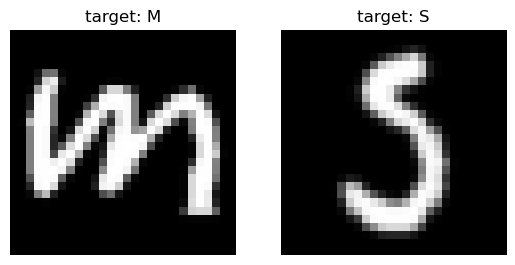

In [10]:
i, j = random.randint(0, 1024), random.randint(0, 1024)
x1,t1 = ds.__getitem__(i)
x2, t2 = ds.__getitem__(j)

print(f"x.shape: {x1.shape}")
print(f"type(t): {type(t1)}")

plt.subplot(1, 2, 1)

draw(x1, f"target: {convert_i2c(t1)}")

plt.subplot(1, 2, 2)
draw(x2, f"target: {convert_i2c(t2)}")
plt.show()

## Building the Masked Dataset

In [11]:
class MaskedDataset(Dataset):
    def __init__(self, ds, min_mask_ratio=0.1, max_mask_ratio=0.5, mask_value=-1):
        
        self.original_dataset = ds
        self.min_mask_ratio = min_mask_ratio
        self.max_mask_ratio = max_mask_ratio
        self.mask_value = mask_value

    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        x, t = self.original_dataset[idx]
        mask_ratio = random.uniform(self.min_mask_ratio, self.max_mask_ratio)
        mask = (torch.rand_like(x) > mask_ratio).float() # 0 to be masked
        masked_x = x * mask + self.mask_value * (1 - mask)
        
        return masked_x, x, t

[NOTE]: Green pixels represent masked pixels

x.shape: torch.Size([784])
type(t): <class 'int'>


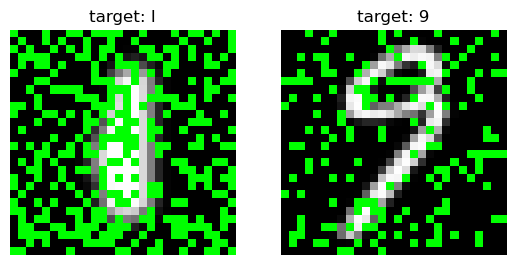

In [12]:
ds_masked = MaskedDataset(ds, min_mask_ratio=0.1, max_mask_ratio=0.5, mask_value=-1)

i, j = random.randint(0, 1024), random.randint(0, 1024)
x1, _, t1 = ds_masked.__getitem__(i)
x2, _, t2 = ds_masked.__getitem__(j)

print("[NOTE]: Green pixels represent masked pixels\n")

print(f"x.shape: {x1.shape}")
print(f"type(t): {type(t1)}")

plt.subplot(1, 2, 1)

draw(x1, f"target: {convert_i2c(t1)}")

plt.subplot(1, 2, 2)
draw(x2, f"target: {convert_i2c(t2)}")
plt.show()

# Implementing the Denoising Autoencoder Using PyTorch

In [13]:
class DAE(nn.Module):
    def __init__(self, in_dim=img_size**2, latent_dim=64, loss_fcn = nn.MSELoss()):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.loss_fcn = loss_fcn
        self.losses = []
        
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim), nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, in_dim), nn.Sigmoid()
        )
        
        
    def forward(self, x): 
        """
        Forward pass through the DAE.
        :param x: Input tensor of shape (batch_size, in_dim)
        :return: Reconstructed output tensor of shape (batch_size, in_dim)
        """
        z = self.encoder(x)
        decoded = self.decoder(z)
        return decoded
    
    def learn(self, dl, epochs=10, lr=0.001):
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0
            for masked_batch, clean_batch, _ in dl:
                y_batch = self.forward(masked_batch)
                loss = self.loss_fcn(y_batch, clean_batch)
                
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                # loss in the epoch
                total_loss += loss.item()*len(masked_batch)
            self.losses.append(total_loss / len(dl.dataset))
        plt.plot(self.losses); plt.xlabel('Epochs');
        plt.yscale('log');
        
        

## Training the DAE on Masked Dataset

In [14]:
# 90% train, 10% test
train_size = int(0.9 * len(ds_masked))
test_size = len(ds_masked) - train_size

train_dataset, test_dataset = random_split(ds_masked, [train_size, test_size])

In [15]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 10/10 [01:04<00:00,  6.47s/it]


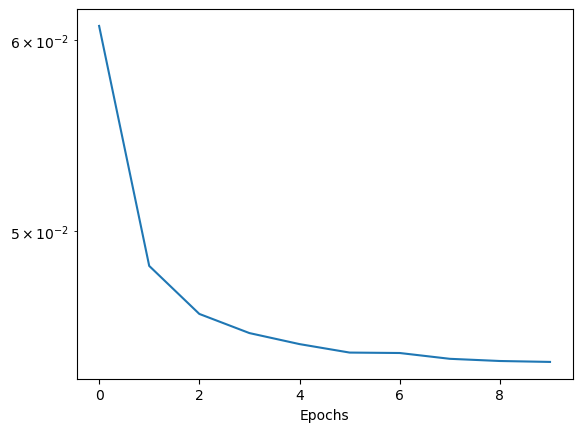

In [35]:
dae = DAE(in_dim=img_size**2, latent_dim=64).to(device)
dae.learn(train_loader, epochs=10, lr=0.01)


### Reconstructing Images using Trained Denoising Autoencoder

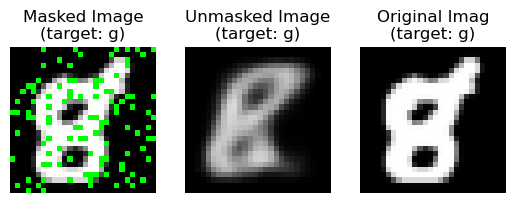

In [36]:
idx1 = random.randint(0, 3204)
x1_masked, x1_clean, t1 = test_dataset.__getitem__(idx1)
x1_unmasked = dae.forward(x1_masked)

plt.subplot(1,3, 1)
draw(x1_masked, f"Masked Image\n(target: {convert_i2c(t1)})")
plt.subplot(1,3, 2)
draw(x1_unmasked, f"Unmasked Image\n(target: {convert_i2c(t1)})")
plt.subplot(1,3, 3)
draw(x1_clean, f"Original Imag\n(target: {convert_i2c(t1)})")

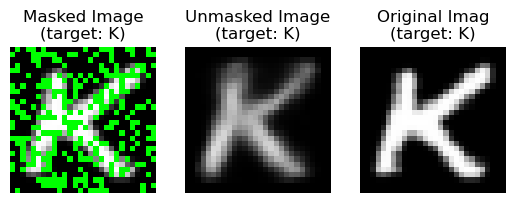

In [37]:
idx2 = random.randint(0, 3204)
x2_masked, x2_clean, t2 = test_dataset.__getitem__(idx2)
x2_unmasked = dae.forward(x2_masked)

plt.subplot(1,3, 1)
draw(x2_masked, f"Masked Image\n(target: {convert_i2c(t2)})")
plt.subplot(1,3, 2)
draw(x2_unmasked, f"Unmasked Image\n(target: {convert_i2c(t2)})")
plt.subplot(1,3, 3)
draw(x2_clean, f"Original Imag\n(target: {convert_i2c(t2)})")